## Description
Using the training data written to file this notebook will:

* Plot class-specific violin plots for each of the feature layers in the training data
* Plot the importance of each feature after applying a model to the data.

In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## Analysis Parameters
* training_data: Name and location of the training data .txt
* class_dict: A dictionary mapping the 'string' name of the classes to the integer values that represent our classes in the training data (e.g. {'No_NNI':0, 'Muy_bajo':1})
* field: This is the name of the column in the original training data shapefile that contains the class labels. This is provided simply so we can remove this attribute before we plot the data

In [2]:
training_data = "results/training_data.txt"

class_dict = {'No_NNI':0, 'Muy_bajo':1, 'Moderado_bajo':2, 'Moderado':3, 'Alto':4, 'Muy_alto':5}

field = 'class'

## Impor training data

In [3]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

In [4]:
dfs = {}

# Insert data into a Pandas DataFrame, then split into features and labels
model_input_df = pd.DataFrame(model_input, columns=column_names)
X = model_input_df.drop(field, axis=1)
y = model_input_df[[field]]

# Fit the standard scaler to all features
scaler = StandardScaler(with_mean=False)
scaler.fit(X);

for key, value in class_dict.items():
    print(key, value)
    # extract values for class from training data
    arr = model_input[model_input[:,0]==value]
    # create a pandas df for ease of use later
    df = pd.DataFrame(arr).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop(field, axis=1)
    # Scale the dataframe
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
    
    dfs.update({key:scaled_df})

No_NNI 0
Muy_bajo 1
Moderado_bajo 2
Moderado 3
Alto 4
Muy_alto 5


## Feature layer violin plots

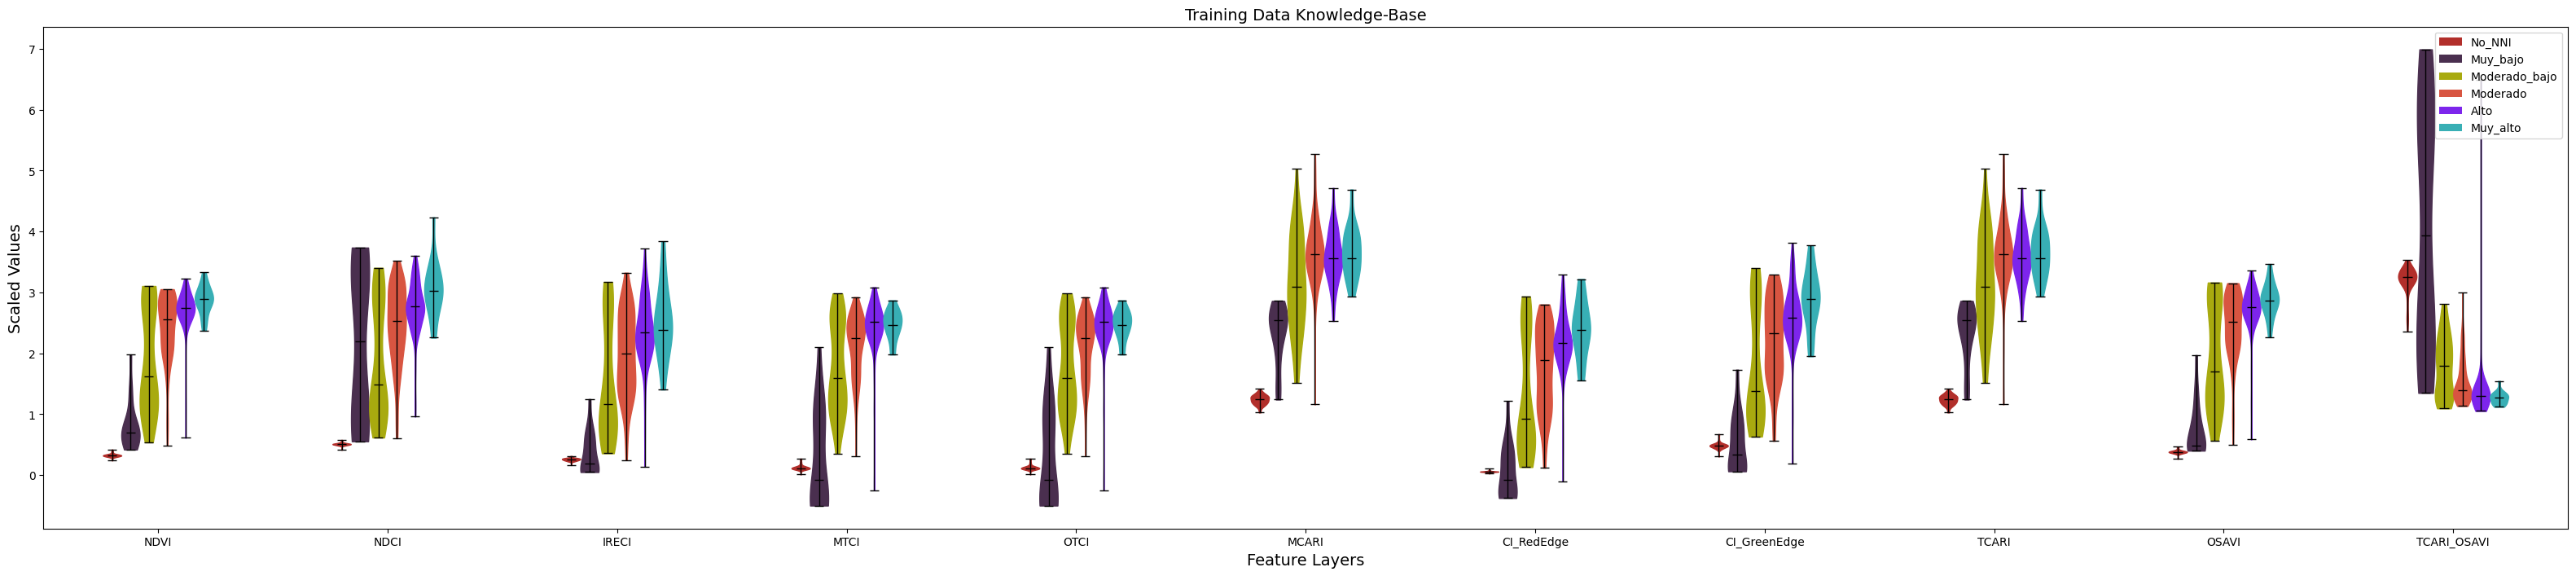

In [5]:
#generate a random list of colors same length as num of classes 
get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(dfs))

#generate list of offsets & widths for plotting
start=-0.2 
end=0.2
offsets = list(np.linspace(start,end,len(dfs)))
if len(dfs) == 2:
    width=0.4
else:
    width=np.abs(offsets[0] - offsets[1])

#create figure and axes 
fig, ax = plt.subplots(figsize=(40,8))

for key, color, offset in zip(dfs,colors, offsets):
    #create violin plots
    pp = ax.violinplot(dfs[key].values,
                       showmedians=True,
                       positions=np.arange(dfs[key].values.shape[1])+offset, widths=width
                      )
    # change the colour of the plots
    for pc in pp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)
    
    #change the line style in the plots
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = pp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

#tidy the plot, add a title and legend
ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5,len(column_names[1:])-.5)
ax.set_ylabel("Scaled Values", fontsize=14)
ax.set_xlabel("Feature Layers", fontsize=14)
ax.set_title("Training Data Knowledge-Base", fontsize=14)
ax.legend([Patch(facecolor=c) for c in colors], [key for key in dfs], loc='upper right');

We can see if a number of our features show good separation between the better and the worst level of NNI classes. If here we appreciate that some features have very different distributions between the classes we can assume this is a good indication that our model will possess the right features for distinguishing between good and bad levels of NNI later on in the workflow.

## Feature Importance
Here we extract classifier estimates of the relative importance of each feature for training the classifier. This is useful for potentially selecting a subset of input bands/variables for model training/classification.

Results will be presented in ascending order with the most important features listed last.

In [6]:
model=RandomForestClassifier(random_state=42)
model.fit(X, y.values.ravel());

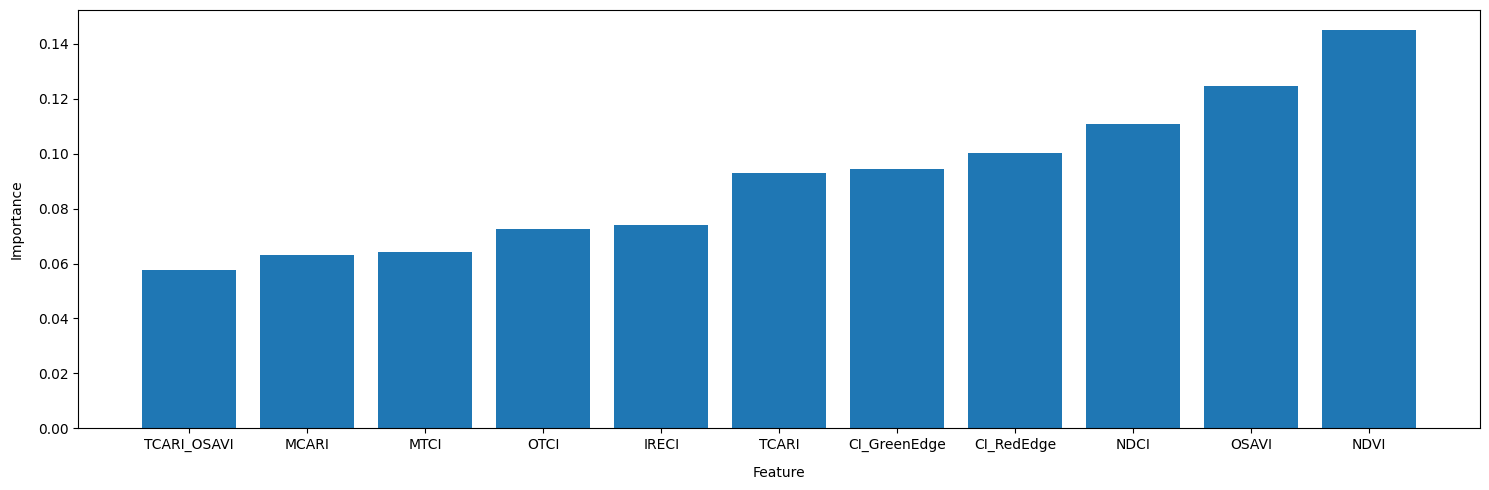

In [7]:
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(15,5))
plt.bar(x=np.array(column_names[1:])[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Feature', labelpad=10)
plt.tight_layout()